# CAPSTONE PROJECT 2: A COMPUTER VISION MODEL WHICH DETECTS BONE FRACTURES IN THE UPPER EXTREMITIES NAMELY: WRISTS, FOREARMS, UPPER ARM, & SHOULDER FRACTURES
#### Modeling



***
Goal: Build two to three different models and identify the best one. <br>
- Fit your models with a training dataset<bf>
Hint: Try a number of different models: you will want to compare their outputs in the
model evaluation stage. For example, if you’re writing a classification model, you should
implement both an entropy model and a Gini impurity model. For hyperparameter tuning,
think of methods like cross-validation.<br>
- Review model outcomes — Iterate over additional models as needed<br>
Hint: you may want to use standard model evaluation metrics such as accuracy, recall,
precision, and F1.<br>
- Identify the final model that you think is the best model for this project<br>
Hint: the most powerful model isn’t always the best one to use. Other considerations
include computational complexity, scalability, and maintenance costs.<br>
Review the following questions and apply them to your analysis:<br>
- Does my data involve a time series or forecasting? If so, am I splitting the train
and test data appropriately?<br>
- Is my response variable continuous or categorical?<br>
***

### Training Models: <br>
We are going to train 3 models: The first being a basic Resnet model, which we will train without using and pretrained data on the model, and then we will do another Resnet Model using pretrained data.  Also as a fun exercise we will include a model which uses segmentation w/bounding boxes rather to see if we achieve a better performance, therefore we will be building a UNet() model as well.

In [251]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
from torch import nn
import albumentations as A
# import torchsummary
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

torch.cuda.empty_cache()

BS=16
LR=0.00005
epochs=20
IS=256
D='cuda' if torch.cuda.is_available() else 'cpu'

num_classes = 7
classes=['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive']
c2l={k:v for k,v in list(zip(classes,list(range(num_classes))))}
l2c={v:k for k,v in c2l.items()}

dir_path=r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2"
train_dir_path = r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\train"
train_img_paths = sorted(os.listdir(r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\train\images"))
train_target_paths = sorted(os.listdir(r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\train\labels"))

val_dir_path = r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\valid"
val_img_paths = sorted(os.listdir(r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\valid\images"))
val_target_paths = sorted(os.listdir(r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\valid\labels"))

test_dir_path = r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\test"
test_img_paths = sorted(os.listdir(r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\test\images"))
test_target_paths = sorted(os.listdir(r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\test\labels"))


In [252]:
def unconvert(width, height, x, y, w, h):

    xmax = int((x*width) + (w * width)/2.0)
    xmin = int((x*width) - (w * width)/2.0)
    ymax = int((y*height) + (h * height)/2.0)
    ymin = int((y*height) - (h * height)/2.0)

    return xmin, ymin, xmax, ymax

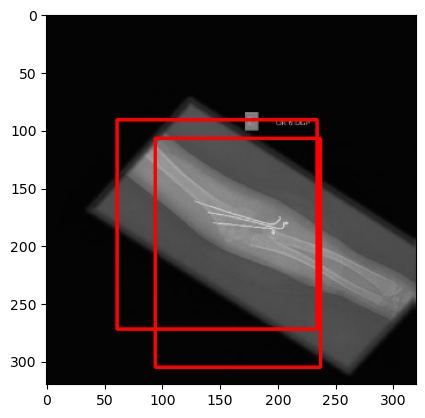

In [253]:
idx=random.randint(0,3000)
# idx=0
ip=os.path.join(train_dir_path,'images',train_img_paths[idx])
tp=os.path.join(train_dir_path,'labels',train_target_paths[idx])

image=cv2.imread(ip)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image=cv2.resize(image,(320,320))

file=open(tp,'r')
target=list(map(float,file.read().split()))[1:]

a=0
while a<len(target):
    bbox=target[a:a+4]
    if len(bbox)==4:
        x,y,w,h=bbox[0], bbox[1], bbox[2], bbox[3]
        xmin,ymin,xmax,ymax=unconvert(320,320,x,y,w,h)
        sp,ep=(xmin,ymin),(xmax,ymax)
        image=cv2.rectangle(image,sp,ep,(255,0,0),2)
    a+=4

plt.imshow(image)
plt.show()

In [254]:
augs=A.Compose([
    A.Resize(IS,IS),
],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']), is_check_shapes=True)

In [255]:
class FractureData(torch.utils.data.Dataset):
    
    def __init__(self, dir_path, img_paths, target_paths, augs=None):
        self.dir_path=dir_path
        self.img_paths=img_paths
        self.target_paths=target_paths
        self.augs=augs
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self,idx):
        ip=os.path.join(self.dir_path,'images',self.img_paths[idx])
        tp=os.path.join(self.dir_path,'labels',self.target_paths[idx])
        
        image=cv2.imread(ip)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        H,W,_=image.shape
        
        file=open(tp,'r')
        target=list(map(float,file.read().split()))
        
        try:
            label=[target.pop(0)]
            bbox=[]    
            i=0
            while i<len(target):
                x,y,w,h=target[i:i+4]
                bbox.append([*unconvert(W,H,x,y,w,h)])
                i+=4
            label=label*len(bbox)
        
            if self.augs!=None:
                data=self.augs(image=image,bboxes=bbox,class_labels=['None']*len(label))
                image=data['image']
                bbox=data['bboxes']
        except:
            if idx+1<len(self.img_paths):
                return self.__getitem__(idx+1)
            else:
                return self.__getitem__(0)
            
        image=torch.Tensor(np.transpose(image,(2,0,1)))/255.0
        bbox=torch.Tensor(bbox).long()
        label=torch.Tensor(label).long()
        
        annot={'boxes':bbox,'labels':label}
        
        return image, annot
    
    def collate_fn(self,batch):
        return tuple(zip(*batch))

##### Declare Dataset (train/validate) and DataLoader classes.

In [256]:
trainset=FractureData(train_dir_path, train_img_paths, train_target_paths, augs)
valset=FractureData(val_dir_path, val_img_paths, val_target_paths, augs)

trainloader=torch.utils.data.DataLoader(trainset,batch_size=BS,collate_fn=trainset.collate_fn)
valloader=torch.utils.data.DataLoader(valset,batch_size=BS,collate_fn=valset.collate_fn)

print(f'Training Data:- {len(trainset)} images divided into {len(trainloader)} batches')

Training Data:- 3631 images divided into 227 batches


### todo:
- Finish defining Base model with backward propogation and training properties
- Import Resnet18 and Resnet30 Models for Training and Testing
- Import a Segmentation model for Training and Testing
- Store and compare Scores to pick best performing model
- Hyperparameter tuning

In [257]:
for image,target in trainloader:
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


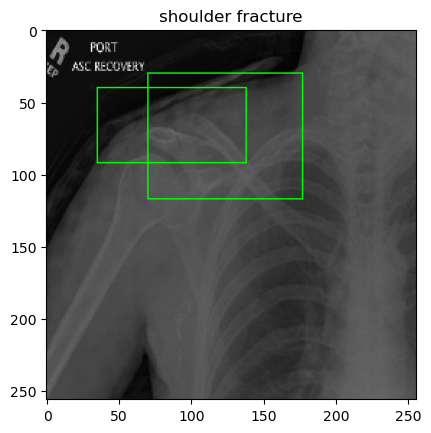

In [258]:
idx=random.randint(0,len(image))
img, tar = image[idx].permute(1,2,0).numpy(), target[idx]

for bbox in tar['boxes']:
    xmin,ymin,xmax,ymax=bbox[0].item(), bbox[1].item(), bbox[2].item(), bbox[3].item()
    sp,ep=(xmin,ymin),(xmax,ymax)
    cv2.rectangle(img,sp,ep,(0,255,0),1)

plt.imshow(img)
plt.title(l2c[tar['labels'][0].item()])
plt.show()

In [259]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model=torchvision.models.detection.fasterrcnn_resnet50_fpn(preTrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(D);

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\micha/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 27.3MB/s]


In [260]:
def trainarc(model, dataloader, opt):
    model.train()
    train_loss=0.0
    
    for images, targets in tqdm(dataloader):
        image=[i.to(D) for i in images]
        target=[{k:v.to(D) for k,v in ele.items()} for ele in targets]
        
        opt.zero_grad()
        losses=model(image,target)
        loss=sum(loss for loss in losses.values())
        loss.backward()
        opt.step()
        
        train_loss+=loss
    return train_loss/len(dataloader)

def evalarc(model, dataloader):
    model.train()
    val_loss=0.0
    with torch.no_grad():
        for images, targets in tqdm(dataloader):
            image=[i.to(D) for i in images]
            target=[{k:v.to(D) for k,v in ele.items()} for ele in targets]

            losses=model(image,target)
            loss=sum( loss for loss in losses.values() )

            val_loss+=loss
    return val_loss/len(dataloader)

In [262]:
best_val_loss=np.Inf

opt=torch.optim.Adam(model.parameters(),lr=LR)

for i in range(epochs):
    train_loss=trainarc(model,trainloader,opt)
    val_loss=evalarc(model,valloader)
    
    print(f"Epochs: {i+1}/{epochs}:- Trainloss: {train_loss}, Valloss: {val_loss}")
    
    if val_loss<best_val_loss:
        torch.save(model.state_dict(),r'C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Models\model1.pt')
        print("Model Updated")
        best_val_loss=val_loss

torch.save(model.state_dict(),r'C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Models\FullyTrainedModel.pt')
print("Fully Trained Model Saved")
print(f"Done. Best Val Loss: {best_val_loss}")

100%|██████████| 22/22 [03:06<00:00,  8.50s/it]


Epochs: 1/20:- Trainloss: 0.35896626114845276, Valloss: 0.3799128234386444
Model Updated


100%|██████████| 22/22 [03:21<00:00,  9.14s/it]


Epochs: 2/20:- Trainloss: 0.37469983100891113, Valloss: 0.4036950170993805


100%|██████████| 22/22 [03:36<00:00,  9.86s/it]


Epochs: 3/20:- Trainloss: 0.3862974941730499, Valloss: 0.4101794958114624


 26%|██▋       | 60/227 [29:04<1:20:54, 29.07s/it]


KeyboardInterrupt: 